In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fakenewsnet/PolitiFactNews.txt
/kaggle/input/fakenewsnet/PolitiFactUser.txt
/kaggle/input/fakenewsnet/BuzzFeedNews.txt
/kaggle/input/fakenewsnet/PolitiFact_real_news_content.csv
/kaggle/input/fakenewsnet/PolitiFact_fake_news_content.csv
/kaggle/input/fakenewsnet/BuzzFeed_real_news_content.csv
/kaggle/input/fakenewsnet/BuzzFeedUserFeature.mat
/kaggle/input/fakenewsnet/BuzzFeedNewsUser.txt
/kaggle/input/fakenewsnet/BuzzFeedUser.txt
/kaggle/input/fakenewsnet/PolitiFactUserUser.txt
/kaggle/input/fakenewsnet/BuzzFeedUserUser.txt
/kaggle/input/fakenewsnet/BuzzFeed_fake_news_content.csv
/kaggle/input/fakenewsnet/PolitiFactUserFeature.mat
/kaggle/input/fakenewsnet/PolitiFactNewsUser.txt
/kaggle/input/onion-notonion-datasets/politifact__clean.csv
/kaggle/input/onion-notonion-datasets/politifact_original.csv
/kaggle/input/onion-notonion-datasets/emergent_phase2_clean_2018_7_2.csv
/kaggle/input/onion-notonion-datasets/not_onion.csv
/kaggle/input/onion-notonion-datasets/snopes_phase2

In [2]:
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,GlobalMaxPool1D,Dropout
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input,GlobalMaxPool1D,Dropout,concatenate
from tensorflow.keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
import re
from nltk.corpus import stopwords #corpus is collection of text
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [3]:
data=pd.read_csv('../input/english-fake-news/task3_engslish_training.csv')

In [4]:
data.head()

,public_id,text,title,our rating
0,1145ea7c,U.S. military officials worked to ensure Presi...,The Texas State Senate – Senator Paul Bettenco...,TRUE
1,2d06d27c,"A 2,500-strong border and coastguard corps cou...",EU army to protect borders,false
2,65d9521c,The federal government has asked school admini...,Emmett Till’s Memorial Sign Shot Up again 35 d...,false
3,e122d505,"Extremely hot days, when temperatures soar to ...",95-Degree Days: How Extreme Heat Could Spread ...,true
4,ad091373,"Rep.Thierry, Shawn Gov. Abbott Grants Sen. Kol...",Texas House of Representatives,partially false


In [5]:
def lower(text):
    lowercase_text = [word.lower() for word in text.split()]
    text=" ".join(lowercase_text)
    return text

In [6]:
data['text'] = data['text'].apply(lambda x:lower(x))
#data['title'] = data['title'].apply(lambda x:lower(x))

In [7]:
for i in range(len(data)):
    if data['our rating'][i] in ['TRUE','FALSE']:        
        data['our rating'][i]=data['our rating'][i].lower()

In [8]:
print(len(data))

1264


<AxesSubplot:xlabel='our rating', ylabel='count'>

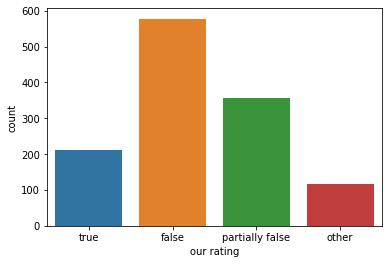

In [9]:
import seaborn as sns
sns.countplot(x='our rating', data=data)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264 entries, 0 to 1263
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   public_id   1264 non-null   object
 1   text        1264 non-null   object
 2   title       1241 non-null   object
 3   our rating  1264 non-null   object
dtypes: object(4)
memory usage: 39.6+ KB


In [11]:
data.isnull().sum()

public_id      0
text           0
title         23
our rating     0
dtype: int64

In [12]:
def replace_title(txt):
    if(txt==''):
        txt.replace('', data['text'])
    

In [13]:
data['title']=data['title'].fillna('')
for i in range(len(data)):
    if data['title'][i]=='':
        data['title'][i]=data['text'][i]

In [14]:
y = pd.get_dummies(data['our rating'])
print(y.tail())

      false  other  partially false  true
1259      1      0                0     0
1260      0      0                1     0
1261      1      0                0     0
1262      0      0                0     1
1263      1      0                0     0


In [15]:
data=pd.concat([data,y],axis=1)

In [16]:
list_classes = ["true", "false", "other", "partially false"]

In [17]:
# get label
X=data.drop(['our rating',"true", "false", "other", "partially false"],axis=1)
y=data[list_classes].values

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True, random_state=42,stratify=y)

In [19]:
X_train_text=X_train['text'].values
X_train_title=X_train['title'].values

In [20]:
X_test_text=X_test['text'].values
X_test_title=X_test['title'].values

In [21]:
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel,TFAutoModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [22]:
tokenizer =BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
MAX_LEN=128

In [24]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            pad_to_max_length = True,
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [25]:
title_input_ids, title_attention_masks = tokenize(X_train_title, MAX_LEN)
text_input_ids, text_attention_masks = tokenize(X_train_text, MAX_LEN)
title_input_test, title_attention_test = tokenize(X_test_title, MAX_LEN)
text_input_test, text_attention_test = tokenize(X_test_text, MAX_LEN)

In [26]:
roberta_model = TFBertModel.from_pretrained('bert-base-uncased')
roberta_model2 = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-04-24 22:26:03.722918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:26:03.724540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:26:03.725571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:26:03.726875: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [27]:
import tensorflow as tf

In [28]:
def create_model(bert_model,bert_model2,learning, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=learning)
    input_title = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_title = tf.keras.Input(shape=(max_len,),dtype='int32')
    input_text=tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_text=tf.keras.Input(shape=(max_len,),dtype='int32')
    
    output1 = bert_model([input_title,attention_title])[0]
    output1 = tf.keras.layers.GlobalMaxPooling1D()(output1)
    output1 = tf.keras.layers.Dropout(0.1)(output1)

    
    
    output2=bert_model2([input_text,attention_text])[0]
    output2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, dropout=0.3))(output2)
    #output2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, dropout=0.3))(output2)
    output2 = tf.keras.layers.GlobalMaxPooling1D()(output2)
    output2 = tf.keras.layers.Dropout(0.1)(output2)

    ensembled= concatenate([output1,output2],axis=-1) 
    
    output = tf.keras.layers.Dense(4, activation='softmax')(ensembled)
    model = tf.keras.models.Model(inputs = ([input_title,attention_title],[input_text,attention_text]),outputs = output)
    model.compile(opt,loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [29]:
model = create_model(roberta_model,roberta_model2,2e-5,MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
______________________________________________________________________________________________

In [30]:
history = model.fit([[title_input_ids,title_attention_masks],[text_input_ids,text_attention_masks]], y_train, validation_split=0.2, epochs=10, batch_size=30)

2022-04-24 22:26:26.189814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-24 22:27:08.673677: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


27/27 [==============================] - 77s 1s/step - loss: 0.5717 - accuracy: 0.4059 - val_loss: 0.5138 - val_accuracy: 0.4680
Epoch 2/10
27/27 [==============================] - 27s 989ms/step - loss: 0.4834 - accuracy: 0.5087 - val_loss: 0.4843 - val_accuracy: 0.5025
Epoch 3/10
27/27 [==============================] - 27s 988ms/step - loss: 0.4355 - accuracy: 0.5978 - val_loss: 0.4637 - val_accuracy: 0.5517
Epoch 4/10
27/27 [==============================] - 27s 988ms/step - loss: 0.3691 - accuracy: 0.6819 - val_loss: 0.4562 - val_accuracy: 0.5714
Epoch 5/10
27/27 [==============================] - 27s 991ms/step - loss: 0.2986 - accuracy: 0.7686 - val_loss: 0.4675 - val_accuracy: 0.5419
Epoch 6/10
27/27 [==============================] - 27s 988ms/step - loss: 0.2350 - accuracy: 0.8663 - val_loss: 0.4710 - val_accuracy: 0.5616
Epoch 7/10
27/27 [==============================] - 27s 991ms/step - loss: 0.1646 - accuracy: 0.9183 - val_loss: 0.5070 - val_accuracy: 0.5517
Epoch 8/10
27

In [31]:
y_preds=model.predict([[title_input_test,title_attention_test],[text_input_test,text_attention_test]])

In [32]:
y_preds=np.argmax(y_preds,axis=1)
y_true=np.argmax(y_test,axis=1)

In [33]:
from sklearn.metrics import f1_score
f1=f1_score(y_true,y_preds, average='weighted')
print("F1-score  :%5f" % (f1))

F1-score  :0.608851
